## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

An A/B test was conducted to test the performance of an old website page compared to a newly developed website page using bootstrapping for hypothesis testing.The goal of this A/B test is to help the  an e-commerce company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability
Import libraries

In [112]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the Dataset

In [113]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Find the number of rows in the Dataset

In [114]:
df.shape[0]

294478

Find the number of unique users in the Dataset

In [115]:
df['user_id'].nunique()

290584

Compute the proportion of users converted

In [116]:
(len(df[df['converted'] == 1 ]) / df.shape[0])*100

11.96591935560551

Identify he number of times the `new_page` and `treatment` don't line up

In [117]:
(df.query('group == "treatment" & landing_page == "old_page"')['user_id'].count()) + (df.query('group == "control" & landing_page == "new_page"')['user_id'].count())

3893

Checking for missing values

**As shown below, all rows do not have any missing values.**

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In the following step, we will remove the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**,since we cannot be sure if this row truly received the new or old page.  

Create a new Dataset (**df2**) that ONLY contains the rows where landing_page and group columns are Aligned.

In [119]:
#create a new dataframe in which old_page and control line up.
df_1= df.query('group == "control" & landing_page == "old_page"')

#create a new dataframe in which new_page and treatment line up.
df_2 = df.query('group == "treatment" & landing_page == "new_page"')

#append rows of df_1 to the end of df_2, returning a new dataframe 
#in which  treatment is aligned with new_page, and control is aligned with old_page.
df2 = df_2.append(df_1)

In [120]:
# Double Check that all rows where the landing_page and group columns don't align were removed - this should be 0
(df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]) + (df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0])

0

Identify the number of unique **user_id**s in **df2**

In [121]:
df2['user_id'].nunique()

290584

Check for duplicate user ids

In [122]:
#add a new boolean column to our DataFrame that will identify a duplicated
#order line item (False=Not a duplicate; True=Duplicate)
df2['is_duplicated'] = df2.duplicated('user_id')

#get the user_id for the non-unique id in df2 ( the user_id that has is_duplicated = True) 
df2.query('is_duplicated')['user_id']

2893    773192
Name: user_id, dtype: int64

Find the row information for the repeated **user_id** 

In [123]:
df2.query('is_duplicated')

,user_id,timestamp,group,landing_page,converted,is_duplicated
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


Remove **one** of the rows with a duplicate **user_id** while keeping the dataframe as **df2**

In [124]:
df2.drop_duplicates(subset=['user_id'], keep='first', inplace=True)

#check that only one of the duplicated rows is removed,
#but the other one is still in the dataframe
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted,is_duplicated
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False


In [125]:
#drop 'is_duplicated' column as it is no longer needed
df2.drop('is_duplicated', axis=1, inplace=True)

In [126]:
#checking that 'is_duplicated' is successfuly dropped
df2.head(1)

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


Computing the probability of an individual converting regardless of the page they receive

In [127]:
#displaying the first few rows of our Dataset
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


Compute the probability of converting regardless of page

In [128]:
df2.query('converted == 1')['converted'].count() / df2.shape[0]

0.11959708724499628

Given an individual received the control page, the probability of converting

In [129]:
(df2.query('group == "control"')['converted']).mean()

0.1203863045004612

Given that an individual received the treatment, the probability of converting

In [130]:
(df2.query('group == "treatment"')['converted']).mean()

0.11880806551510564

Computing the probability of receiving the new page

In [131]:
df2.query('landing_page == "new_page"')['landing_page'].count() / df2.shape[0]

0.50006194422266881

## Q: Do you think there is evidence that one page leads to more conversions? 

### To answer this Question we need to comapare the probabilities we've calculated : 
- **Given that an individual was in the treatment group, the probability they converted is 0.118807**
- **Given that an individual was in the control group, the probability they converted is 0.120386**
#### From the above calculated probabilities, we found that old page does better, but by a very tiny margin. Due to almost similar perforamnce of both pages,we cannot state with certainty that one page leads to more conversions.
#### In other words,there is no evidence that one page leads to more conversions as the probabilities of conversions given that an individual was in the "treatment" group or in the "control" group are almost equel.

<a id='ab_test'></a>
### Part II - A/B Test

#### Hypotheses


$$H_0: p_{new} - p_{old} \leq 0 $$

$$H_1: p_{new} - p_{old} >   0 $$


Compute the **conversion rate** for $p_{new}$ under the null

In [132]:
p_new = df2['converted'].mean()
print(p_new)

0.119597087245


Compute the **conversion rate** for  $p_{old}$  under the null

In [133]:
p_old = df2['converted'].mean()
print(p_old)

0.119597087245


Find $n_{new}$

In [134]:
n_new = len(df2.query('landing_page == "new_page"'))
print(n_new)

145310


Find $n_{old}$

In [135]:
n_old = len(df2.query('landing_page == "old_page"'))
print(n_old)

145274


Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null

In [136]:
new_page_converted = np.random.choice([0,1], size = n_new, p=[(1-p_new), p_new])

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null

In [137]:
old_page_converted = np.random.choice([0,1], size = n_old, p=[(1-p_old), p_old])

Find $p_{new}$ - $p_{old}$ (the difference in the conversion rate) for the simulated values above

Since new_page_converted and old_page_converted  have different sizes,145310 and 145274 values respectively, we cannot find **p_diff = $p_{new}$ - $p_{old}$** directly. 
And since,the differernce in sizes is **only 36 values** of thousands, 
i.e. new_page_converted has 36 more values than old_page_converted,
**we can truncate the excess in new_page_converted**

In [138]:
new_page_converted = new_page_converted[ : 145274]

#check the new size of new_page_converted
print(len(new_page_converted))

145274


Since both new_page_converted and old_page_converted are having the same number of values now,
we can easily find $p_{new}$ - $p_{old}$ as follows:

In [139]:
diff = (new_page_converted.mean()) - (old_page_converted.mean())
print(diff)

-0.000165205060782


Simulate 10,000 $p_{new}$ - $p_{old}$ values using the same process of the ones that have been calculated in last two parts above

In [140]:
p_diffs= []

for _ in range (10000):
    new_page_converted = np.random.choice([0,1], size = n_new, p=[(1-p_new), p_new])    
    old_page_converted = np.random.choice([0,1], size = n_old, p=[(1-p_old), p_old])
    diff = (new_page_converted.mean()) - (old_page_converted.mean())
    p_diffs.append(diff)

Plot a histogram of the **p_diffs**

In [141]:
# convert to numpy array
p_diffs = np.array(p_diffs)

Text(0.5,0,'\n Difference in Probability')

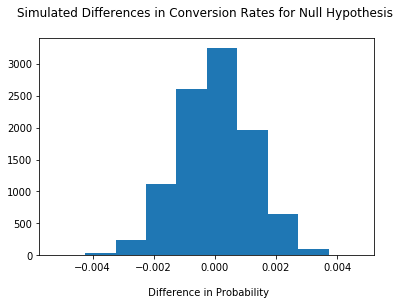

In [142]:
# plot distribution
plt.hist(p_diffs);
plt.title("Simulated Differences in Conversion Rates for Null Hypothesis \n", fontsize=12)
plt.xlabel("\n Difference in Probability", fontsize=10)

Compute the proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [143]:
#computing the obsereved difference
obs_new_converted = df.query('landing_page == "new_page"')['converted'].mean()
obs_old_converted = df.query('landing_page == "old_page"')['converted'].mean()

obs_diff = obs_new_converted - obs_old_converted

In [144]:
# computing the proportion of p_diffs that is greater than obs_diff
(p_diffs > obs_diff).mean()

0.91900000000000004

## Q: explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- **obs_diff** represents the difference between converted rates of new page and old page, based on our dataset.

- **p_diffs** represents the simulated difference between converted rates of new page and old page, based on 10,000 simulated samples.

- The **p-value** was calculated by computing the proportion of **p_diffs** that are greater than **obs_diff** observed in our dataset. The p-value determines the probability of obtaining our observed statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.

- **with a p-value of 0.9157, the difference in the conversion rate for the control and treatment groups does NOT appear to be significant.** Since the p-value is far greater than the typical $\alpha$ level of 0.05 in business studies. (An $\alpha$ level of 0.05 indicates that we have a 5% chance of committing a Type I error if the null is true.) As such, **we would fail to reject the null hypothesis.** 

- And based on these results, **It looks like the company should stay with the old page as there is No conversion advantage with new web page.** Although old and new web pages perform almost similarly, old web page(as the numbers show) performed slightly better.

### Comparison to built in t-test

Calculate number of rows for old and new

In [145]:
import statsmodels.api as sm

df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [146]:
convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

convert_old ,n_old , convert_new , n_new

(17489, 145274, 17264, 145310)

Use `stats.proportions_ztest` to compute your test statistic and p-value

In [147]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')
print ('The z_score = ',z_score)
print('The p_value = ', p_value )

The z_score =  -1.31092419842
The p_value =  0.905058312759


In [148]:
from scipy.stats import norm

print(norm.cdf(z_score)) # Tells us how significant our z-score is
print(norm.ppf(1-(0.05/2))) # Tells us what our critical value at 95% confidence is

0.094941687241
1.95996398454


### Q: What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages? 

### Answer
 - **Since the z-score of -1.31092419842 is less than the critical value of 1.95996398454. So, we fail to reject the null hypothesis.**

 - As regards  to the conversion rates of the old and new pages, we found that old page is only minutely better than new page.
 - Spoken plainly, **Old Page** (17489/145274) is **statistically different and slightly better** than **New Page** (17264/145310). However, we would expect their long-term performance to be different from one another.
 - These values agree with the findings in parts j. and k as the calculated values align with those obtained during the bootstrapped hypothesis testing done above.

<a id='regression'></a>
### Part III - A regression approach

#### Q: Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

- **Logistic Regression**

Create dummy variables and add an intercept

In [149]:
df2['intercept'] = 1
df2['ab_page']= pd.get_dummies(df['landing_page'])['new_page'] # means Use the 1 for new_page and treatment
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


Instantiate and fit the model

In [150]:
Logit_mod = sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])
results = Logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Provide the summary of the model below

In [151]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 07 Dec 2018   Pseudo R-squ.:               8.077e-06
Time:                        00:59:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

### Q: What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with the regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

#### Hyotheses associated with regression model are  as follows  :

$$H_0: p_{new} - p_{old} = 0 $$

$$H_1: p_{new} - p_{old} \neq  0 $$


- The hypotheses associated with Logistic Regression is aimed to determine only one of two possible outcomes: If the conversion rate new page is **equal** to one of the old page (Null Hypothesis) or it is **different** (Alternative Hypothsis).
- The p-value associated with ab_page column in this case =  0.190 which is much lower than the p-value calculated using the z-score function that equals to 0.905. 
- The p-values are different since **we are performing a two-tailed test in Logistic Regression** NOT a one-tailed test as done before.
- In Logistic Regression, the returned p-value associated with ab_page column,that is equal to 0.190, is still greater than the typical $\alpha$ level of 0.05 in business studies.Therefore,  **we would fail to reject the null hypothesis.** 
- **This would also suggests that there is no significant contribution from page, on which the user is landing, to differences in conversion rates for the new and old pages.** 

### Q: Now, you are considering other things that might influence whether or not an individual converts. 
### Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

### Advantages :
1) Considering relevant factors to be added into our Logitic Regression Model, can prevent bias in the estimate of the other regression coefficient, but can lead to an increase in their variances. Since we never know what are the real relevant variables, we need to balance this bias-variance trade-off.

2) This would allow our Logistic Regression to provide a quantified value for the strength of the association adjusting for all the explanatory variables considered (i.e. removes confounding effects). The exponential of coefficients correspond to odd ratios for the given factor.


### Disadvantages :
1) This requires having enough participants with each possible set of explanatory variable added to the regression model. Using interaction or adding factors that a rare therefore reduce considerably the power of the analysis. This can be avoided by carefully considering this issue at the planning phase to make sure the sample size is large enough.

2) Defining variables to enter in the model, adding, or removing explanatory variables can be complicated and must be carefully planned. If not avoided,important collinearity between variables will cause over-adjustement. This issue can be controled if we considered introducing interaction terms if we are to believe some factors might increase the effects of others on our outcome.

3) Even with additional factors we can never account for all influencing factors or accomodate them. Plus, small pilots and pivots sometimes work better in practice than long-drawn research without execution.

### Now, along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives.

#### Adding an additional Explanatory variable 'country' to the model

Additional information regarding conversion rates is available for user country. 

In [152]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


Read in the **countries.csv** Dataset

In [153]:
df_countries = pd.read_csv('./countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [154]:
#checking for any duplicates 
(df_countries['user_id'].nunique()) == (df_countries.shape[0])

True

#### Since the number of unique values in 'user_id' equals to the number of rows in the dataset ,This indicates that there is no duplicates in the Countries Dataset.

Merge together the two Datasets on the approporiate rows

In [155]:
df_new = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [156]:
#checking the unique values of country column
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

Create dummy variables for the country columns

In [157]:
#creating the dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [158]:
#checking the number of users in each country 
df_new['country'].astype(str).value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [159]:
### Fit the Logistic Regression Model And Obtain the Results
df_new['intercept'] = 1

log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA','UK', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 07 Dec 2018   Pseudo R-squ.:               2.323e-05
Time:                        00:59:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

### Q: Does it appear that country had an impact on conversion? Provide the statistical output as well as a written response to answer this question.

- **Once again,the p-values for Canada and UK are 0.130 and 0.457, respectively. It appears that the p-values for the stated countries are greater than a 0.05 $\alpha$ level.**
- **This suggests that we fail to reject the Null Hypothesis.** 
- **We can conclude that : On it's own, there is NO significant contribution from the country, where the user lives, to differences in conversion rates for the new and old pages.**

## After looking at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. 

Create the necessary additional columns

In [160]:
#creating the necessary additional columns
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


Fit the new Logistic Regression Model and 

In [161]:
### Fit the Logistic Regression Model And Obtain the Results
df_new['intercept'] = 1

log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA','UK', 'ab_page','CA_page','UK_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


Provide the summary results, and your conclusions based on the results.

In [162]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 07 Dec 2018   Pseudo R-squ.:               3.482e-05
Time:                        00:59:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

According to the summary results provided , **None** of the p-values associated with the variables **is below the significance level of 0.05 ($\alpha$ level).** This means that **we fail to reject the Null Hypothesis** Moreover, **there is NO sufficient evidence** suggesting that there is an interaction between country and page received that will predict whether a user converts or not.

### Looking at the larger picture, based on the available information, we DO NOT have sufficient evidence to suggest that the new page results in more conversions than the old page as the old page performane was found to be better (by miniscule values only) than the one of the new page as computed by different techniques. Hence, fail to reject the Null Hypothesis.
- **Important Note:** These inferences are strictly based on  the data on hand. **The above analysis acknowledges its limitations due to factors not included in the data.**


In [163]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0